# Sem Flowmeter. Mesmo setup com dataset antigo.

## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shap
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Run the data preparation notebook
#testdf = np.load("npy_files/X_input.npy", allow_pickle=True)
testdf = np.load("npy_files/X_input.npy", allow_pickle=True)

X_input = testdf[:-1,:-2].astype(np.float32)
anomaly_list = testdf[:-1,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:-1,-2]
timestamps = pd.to_datetime(timestamps)

c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.DataFrame(timestamps).head()

,0
0,2020-02-01 00:23:08
1,2020-02-01 00:57:19
2,2020-02-01 01:30:41
3,2020-02-01 02:04:23
4,2020-02-01 02:37:54


In [3]:
pd.DataFrame(X_input).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.978,10.110,-0.012,-0.014,-0.014,-0.014,-0.014,8.642,9.736,9.728,...,40.0,5.0,6.0,39.0,39.0,39.0,39.0,40.0,109.0,1942.0
1,8.894,10.028,-0.012,-0.012,-0.014,-0.014,-0.014,8.552,9.644,9.706,...,39.0,4.0,6.0,38.0,38.0,39.0,38.0,39.0,99.0,1903.0
2,8.816,10.164,-0.014,-0.012,-0.014,-0.014,-0.014,8.474,9.788,9.716,...,39.0,4.0,6.0,38.0,39.0,39.0,39.0,39.0,99.0,1923.0
3,9.060,8.848,-0.014,-0.014,-0.014,-0.014,-0.016,8.720,9.858,9.710,...,39.0,5.0,5.0,38.0,39.0,38.0,39.0,39.0,99.0,1912.0
4,8.930,9.918,-0.012,-0.012,-0.014,-0.014,-0.014,8.506,9.602,9.716,...,39.0,5.0,5.0,38.0,38.0,37.0,38.0,39.0,100.0,1883.0


In [4]:
X_input.shape

(11626, 100)

#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [5]:
# Define input dimension
input_dim = X_input.shape[1]

'''# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)'''

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(256, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(128, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(64, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(16, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(64, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(128, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(256, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)
autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

## Running the Autoencoder

#### Operator to tell the first cycle of a given month

In [6]:
print(timestamps[0])
print(timestamps[-1])

2020-02-01 00:23:08
2020-09-01 02:57:53


In [7]:
np.where(timestamps == '2020-02-01 10:35:00')

(array([], dtype=int64),)

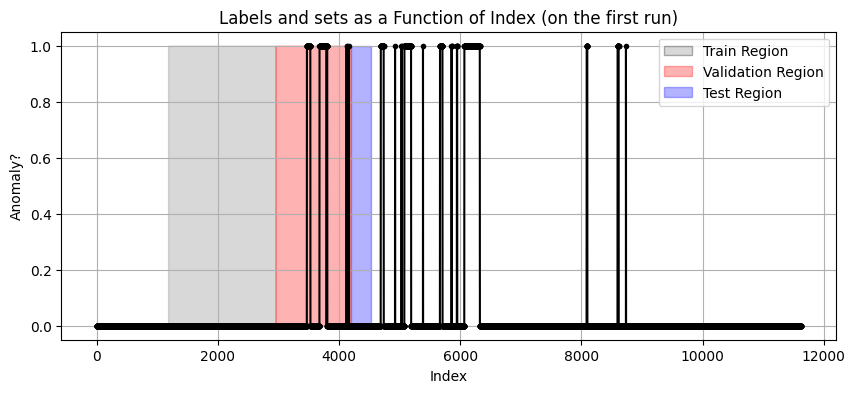

In [8]:
labels_int = [int(label) for label in anomaly_list]

# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
index_mar = 1180+1 #March 1st index (+1 bc 1st cycle is problematic)
index_apr = 2954
index_mai = 4193 
index_jun = 5815
index_jul = 7611
time_delta = 7 # how many days at a time you want to test
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set
last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=2*time_delta))

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, '.-', color='black', label='Labels')
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_mar) & (np.arange(len(anomaly_list)) < index_apr), color='gray', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_apr) & (np.arange(len(anomaly_list)) < index_mai), color='red', alpha=0.3)
plt.fill_between(range(len(anomaly_list)), 0, 1, where=(np.arange(len(anomaly_list)) >= index_mai)& (np.arange(len(anomaly_list)) < last_test_index), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels and sets as a Function of Index (on the first run)')
plt.grid(True)
plt.show()

#### Boundary condition: the primordial run

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 90.9352 - val_loss: 92.8004
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.8995 - val_loss: 88.5204
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9152 - val_loss: 80.6498
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.1683 - val_loss: 73.1424
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5079 - val_loss: 65.7779
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6228 - val_loss: 58.7556
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2150 - val_loss: 54.2748
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1202 - val_loss: 50.9858
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2649 - val_loss: 48.8011
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5799 - val_loss: 47.1406
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0076 - val_loss: 45.8544
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

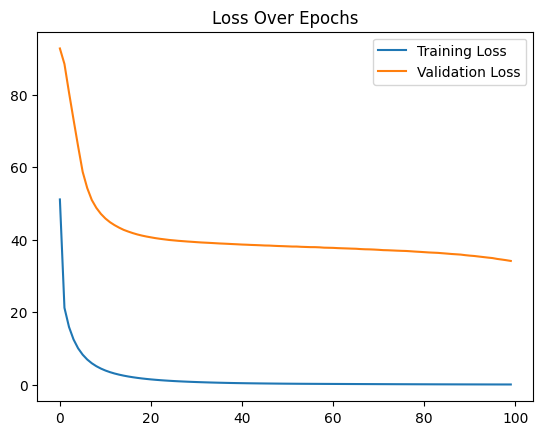

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Threshold:  0.15662485
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 337]))
len(test_loss) = len(test_data)?: (338, 338)


In [9]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_input

#new variables for the moving window problem
test_loss = []
preds_list = []
val_preds_list = []
threshold_list = []
k_list = []
beta_list = []
batch_limits = []

normal_train_data = np.empty((0, input_dim), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, input_dim), dtype=np.float32)
normal_val_data = np.empty((0, input_dim), dtype=np.float32)
anomalous_val_data = np.empty((0, input_dim), dtype=np.float32)


test_cycle_normalized = np.empty((1, input_dim), dtype=np.float32)
test_cycle = np.empty((1, input_dim), dtype=np.float32)
good_cycles = np.empty((1,input_dim), dtype=np.float32)







# Split the data and labels
train_data = data[index_mar:index_apr].astype(np.float32)
val_data = data[index_apr:index_mai]
test_data = data[index_mai:last_test_index].astype(np.float32) # Assuring we only test 1 week at a time
batch_limits.append([index_mai, last_test_index])


train_labels = labels[index_mar:index_apr]
train_len = len(train_labels)
val_labels = labels[index_apr:index_mai]
test_labels = labels[index_mai:last_test_index] # Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)
    else:
        anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :]), axis=0)


normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)
val_data_normalized = np.zeros_like(val_data)
normal_val_data_normalized = np.zeros_like(normal_val_data)
anomalous_val_data_normalized = np.zeros_like(anomalous_val_data)



scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 3 (columns 14-20)
normal_train_data_normalized[:, 14:21] = scaler.fit_transform(normal_train_data[:, 14:21].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,14:21] = scaler.transform(test_data[:, 14:21].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,14:21] = scaler.transform(val_data[:, 14:21].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 4 (columns 21-27)
normal_train_data_normalized[:, 21:28] = scaler.fit_transform(normal_train_data[:, 21:28].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,21:28] = scaler.transform(test_data[:, 21:28].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,21:28] = scaler.transform(val_data[:, 21:28].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 5 (columns 28-34)
normal_train_data_normalized[:, 28:35] = scaler.fit_transform(normal_train_data[:, 28:35].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,28:35] = scaler.transform(test_data[:, 28:35].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,28:35] = scaler.transform(val_data[:, 28:35].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 6 (columns 35-41)
normal_train_data_normalized[:, 35:42] = scaler.fit_transform(normal_train_data[:, 35:42].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,35:42] = scaler.transform(test_data[:, 35:42].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,35:42] = scaler.transform(val_data[:, 35:42].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 6 (columns 42-48)
normal_train_data_normalized[:, 42:49] = scaler.fit_transform(normal_train_data[:, 42:49].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,42:49] = scaler.transform(test_data[:, 42:49].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,42:49] = scaler.transform(val_data[:, 42:49].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 7 (columns 49-55)
normal_train_data_normalized[:, 49:56] = scaler.fit_transform(normal_train_data[:, 49:56].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,49:56] = scaler.transform(test_data[:, 49:56].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,49:56] = scaler.transform(val_data[:, 49:56].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 8 (columns 56-62)
normal_train_data_normalized[:, 56:63] = scaler.fit_transform(normal_train_data[:, 56:63].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,56:63] = scaler.transform(test_data[:, 56:63].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,56:63] = scaler.transform(val_data[:, 56:63].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 9
normal_train_data_normalized[:, 63:70] = scaler.fit_transform(normal_train_data[:, 63:70].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,63:70] = scaler.transform(test_data[:, 63:70].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,63:70] = scaler.transform(val_data[:, 63:70].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 10
normal_train_data_normalized[:, 70:77] = scaler.fit_transform(normal_train_data[:, 70:77].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,70:77] = scaler.transform(test_data[:, 70:77].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,70:77] = scaler.transform(val_data[:, 70:77].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 11
normal_train_data_normalized[:, 77:84] = scaler.fit_transform(normal_train_data[:, 77:84].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,77:84] = scaler.transform(test_data[:, 77:84].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,77:84] = scaler.transform(val_data[:, 77:84].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 12
normal_train_data_normalized[:, 84:91] = scaler.fit_transform(normal_train_data[:, 84:91].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,84:91] = scaler.transform(test_data[:, 84:91].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,84:91] = scaler.transform(val_data[:, 84:91].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 13
normal_train_data_normalized[:, 91:98] = scaler.fit_transform(normal_train_data[:, 91:98].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,91:98] = scaler.transform(test_data[:, 91:98].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,91:98] = scaler.transform(val_data[:, 91:98].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

'''# Fit and transform sensor 14
normal_train_data_normalized[:, 98:105] = scaler.fit_transform(normal_train_data[:, 98:105].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,98:105] = scaler.transform(test_data[:, 98:105].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,98:105] = scaler.transform(val_data[:, 98:105].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)'''


# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 98] = scaler.fit_transform(normal_train_data[:, 98].reshape(-1, 1)).flatten()
test_data_normalized[:, 98] = scaler.transform(test_data[:, 98].reshape(-1, 1)).flatten()
val_data_normalized[:, 98] = scaler.transform(val_data[:, 98].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 99] = scaler.fit_transform(normal_train_data[:, 99].reshape(-1, 1)).flatten()
test_data_normalized[:, 99] = scaler.transform(test_data[:, 99].reshape(-1, 1)).flatten()
val_data_normalized[:, 99] = scaler.transform(val_data[:, 99].reshape(-1, 1)).flatten()


#Separate into normal and anomalous data
for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)


# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30,
    validation_data=(normal_val_data_normalized, normal_val_data_normalized),
    verbose=1
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_val = autoencoder.predict(val_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

reconstructions_val_normal = autoencoder.predict(normal_val_data_normalized)
val_loss_normal = tf.keras.losses.mae(reconstructions_val_normal, normal_val_data_normalized)

if 1 in val_labels:
    y_true = (np.array(val_labels) != 0).astype(int)
    scores = np.array(val_loss)

    # 1. Calculate precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve(y_true, scores)

    # Note: precision and recall arrays have one extra element compared to thresholds.
    # We'll compute F1 scores for the thresholds only.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
    # 2. Identify the best threshold (maximizing F1 score)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
##############################################################REPLACE TYKEY'S FENCES WITH 99-PERCENTILE
    # Compute quartiles and IQR
    Q1 = np.percentile(val_loss_normal, 25)
    Q3 = np.percentile(val_loss_normal, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    
else:
    best_threshold = np.percentile(val_loss, 99) #REPLACE max(val_loss) by 99-percentile

    # Compute quartiles and IQR
    Q1 = np.percentile(val_loss_normal, 25)
    Q3 = np.percentile(val_loss_normal, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    #beta = best_threshold/np.percentile(val_loss, 99)

threshold_list.append(best_threshold)
#beta_list.append(beta)
k_list.append(k)
print("Threshold: ", best_threshold)



# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
val_pred = predict(autoencoder, val_data_normalized, best_threshold).numpy()
pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy()
preds_list = np.concatenate((preds_list, pred_aux), axis=0)
'''pred_val_aux = val_labels #predict(autoencoder, normal_val_data_normalized, best_threshold)
val_preds_list = np.concatenate((val_preds_list, pred_val_aux), axis=0)'''
print("pred_aux:", np.unique(pred_aux, return_counts=True))

test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
print(f"len(test_loss) = len(test_data)?: {len(test_loss), test_data.shape[0]}")


In [10]:
test_loss

[np.float32(0.085711196),
 np.float32(0.046799816),
 np.float32(0.04539289),
 np.float32(0.043921635),
 np.float32(0.043550726),
 np.float32(0.04367627),
 np.float32(0.04791415),
 np.float32(0.04181945),
 np.float32(0.04201583),
 np.float32(0.04270973),
 np.float32(0.06418488),
 np.float32(0.04325501),
 np.float32(0.044376608),
 np.float32(0.041884046),
 np.float32(0.042302113),
 np.float32(0.04299455),
 np.float32(0.042837635),
 np.float32(0.045910377),
 np.float32(0.057968117),
 np.float32(0.04565731),
 np.float32(0.046059716),
 np.float32(0.046335496),
 np.float32(0.040432625),
 np.float32(0.040212307),
 np.float32(0.03287781),
 np.float32(0.032099295),
 np.float32(0.031235933),
 np.float32(0.10392042),
 np.float32(0.035385005),
 np.float32(0.031390272),
 np.float32(0.031425882),
 np.float32(0.030930936),
 np.float32(0.03078521),
 np.float32(0.03019709),
 np.float32(0.02981105),
 np.float32(0.033373162),
 np.float32(0.029856402),
 np.float32(0.029740902),
 np.float32(0.029923923),
 

In [11]:
X_input[index_mai:,:].shape

(7433, 100)

In [12]:
test_loss[:10]

[np.float32(0.085711196),
 np.float32(0.046799816),
 np.float32(0.04539289),
 np.float32(0.043921635),
 np.float32(0.043550726),
 np.float32(0.04367627),
 np.float32(0.04791415),
 np.float32(0.04181945),
 np.float32(0.04201583),
 np.float32(0.04270973)]

In [13]:
len(test_loss[index_mai:])

0

#### Plotting the threshold with the test sets

In [14]:
normal_test_data_normalized = np.empty((0, input_dim), dtype=np.float32)  # Empty array with correct shape
anomalous_test_data_normalized = np.empty((0, input_dim), dtype=np.float32)
for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data_normalized = np.concatenate((normal_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_test_data_normalized = np.concatenate((anomalous_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
reconstructions_test_normal = autoencoder.predict(normal_test_data_normalized)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data_normalized)

try:
    reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data_normalized)
    anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data_normalized)

    # Plot both losses on the same histogram
    plt.hist(normal_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Anomalous')

    plt.xlabel("Reconstruction Loss")
    plt.ylabel("Number of Examples")
    plt.legend(loc='upper right')
    plt.title("Reconstruction Loss for Normal and Anomalous Data")
    plt.axvline(x=best_threshold, color='black', linestyle='--')
    #plt.ylim((0, 40))
    plt.show()
except:
    print("No anomalies in the test set")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
No anomalies in the test set


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


#### Moving window

Cycle: 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 2/16. k = 5.811983108520508


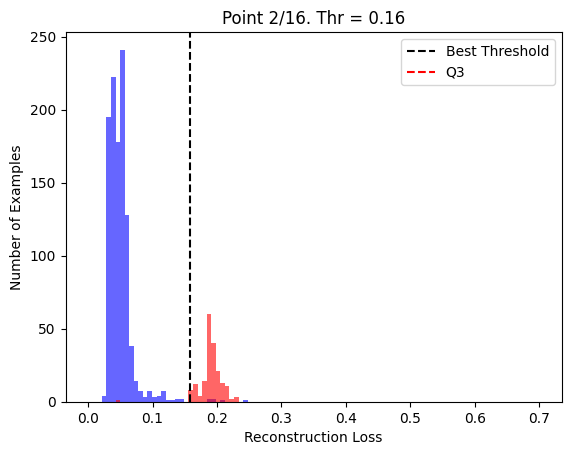

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 56, 228]))
Threshold:  0.1577661
len(test_loss) = len(test_data)?: (284, 284)
Cycle: 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 3/16. k = 5.744037628173828


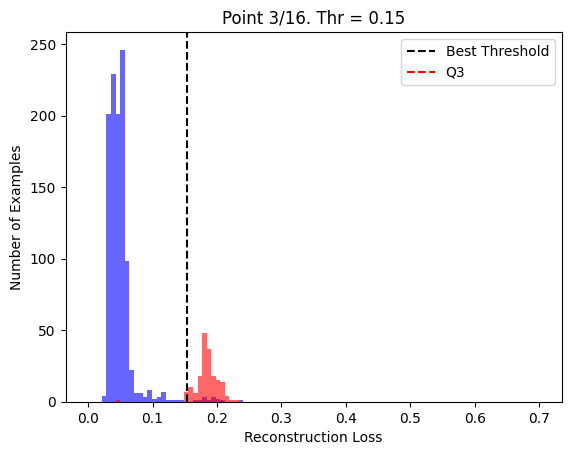

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
pred_aux: (array([False,  True]), array([116, 419]))
Threshold:  0.15273435
len(test_loss) = len(test_data)?: (535, 535)
Cycle: 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 4/16. k = 11.845633506774902


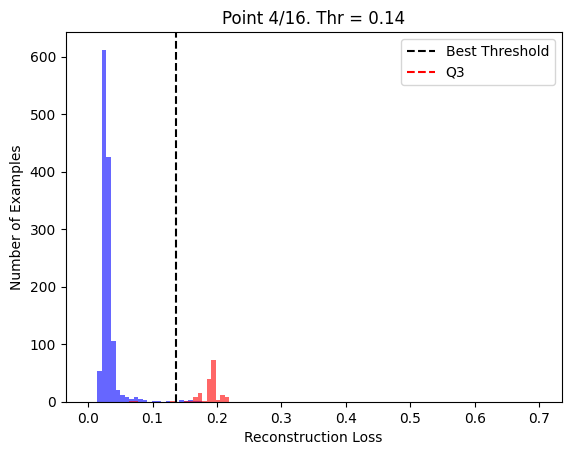

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  5, 306]))
Threshold:  0.13581623
len(test_loss) = len(test_data)?: (311, 311)
Cycle: 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 5/16. k = 9.350605964660645


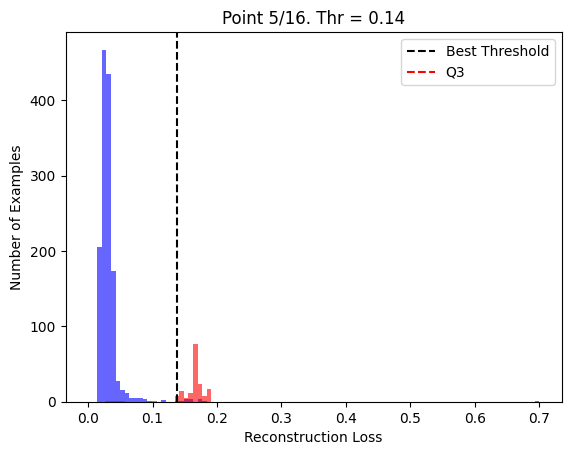

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([116, 353]))
Threshold:  0.13744666
len(test_loss) = len(test_data)?: (469, 469)
Cycle: 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 6/16. k = 9.995623588562012


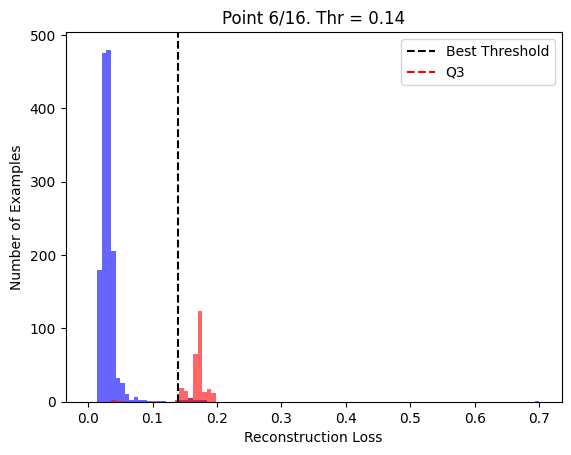

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([194, 255]))
Threshold:  0.13980904
len(test_loss) = len(test_data)?: (449, 449)
Cycle: 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 7/16. k = 6.01686954498291


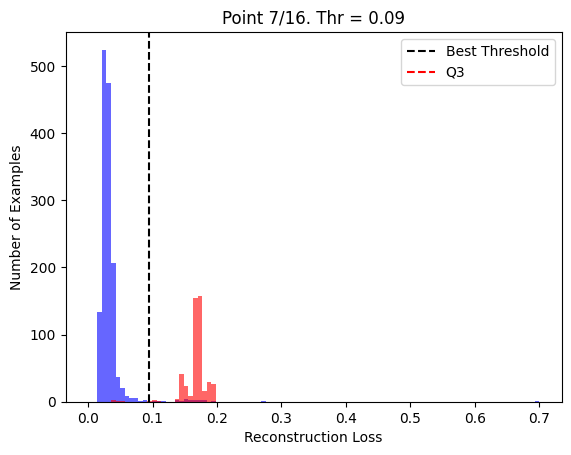

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 538]))
Threshold:  0.09433257
len(test_loss) = len(test_data)?: (539, 539)
Cycle: 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
Point 8/16. k = 5.9817399978637695


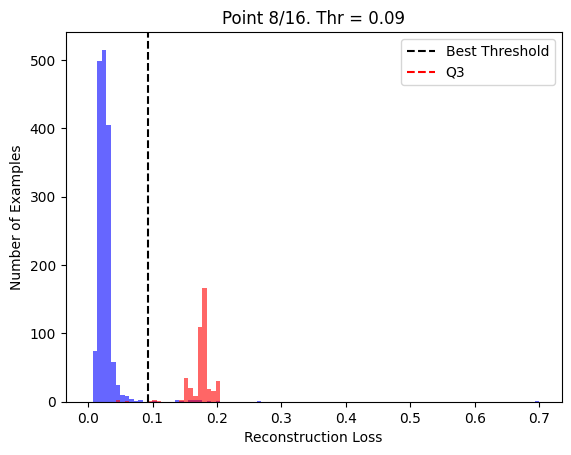

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 315]))
Threshold:  0.09323773
len(test_loss) = len(test_data)?: (316, 316)
Cycle: 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 9/16. k = 8.645706176757812


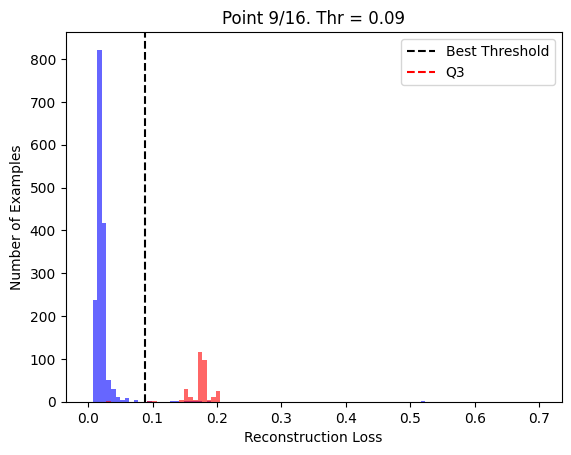

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([ True]), array([390]))
Threshold:  0.08841846
len(test_loss) = len(test_data)?: (390, 390)
Cycle: 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 10/16. k = 10.346601486206055


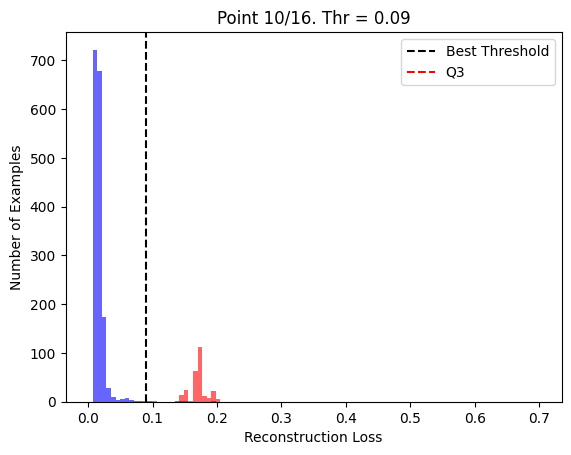

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 10, 440]))
Threshold:  0.08915878
len(test_loss) = len(test_data)?: (450, 450)
Cycle: 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Point 11/16. k = 8.618605613708496


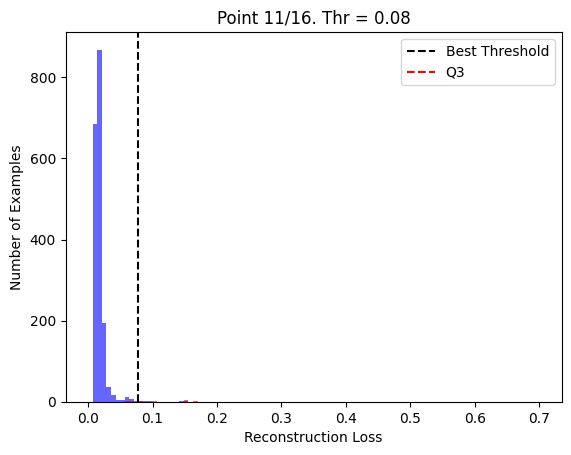

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 24, 496]))
Threshold:  0.076794215
len(test_loss) = len(test_data)?: (520, 520)
Cycle: 11/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
Point 12/16. k = 11.812850952148438


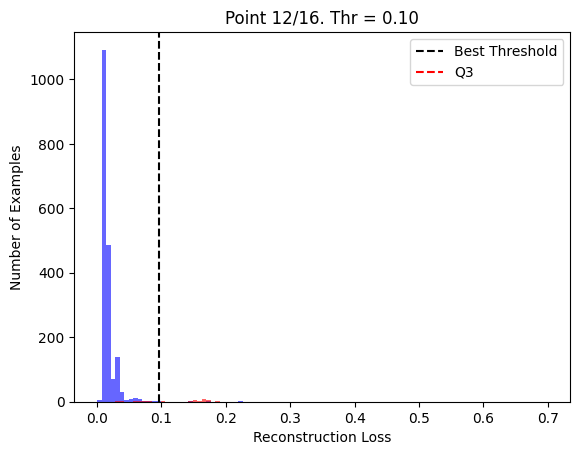

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  2, 448]))
Threshold:  0.097028114
len(test_loss) = len(test_data)?: (450, 450)
Cycle: 12/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Point 13/16. k = 13.202412605285645


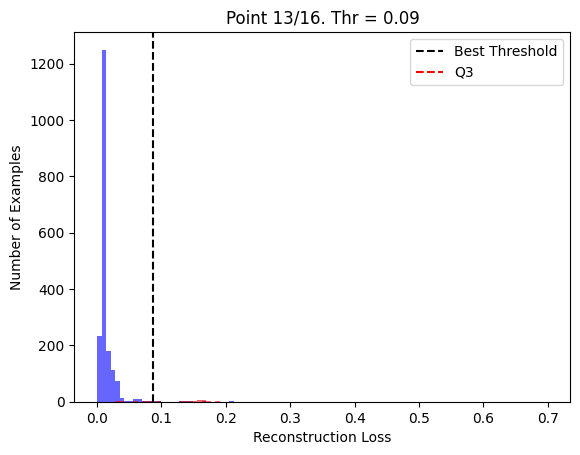

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([  1, 415]))
Threshold:  0.0876235
len(test_loss) = len(test_data)?: (416, 416)
Cycle: 13/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Point 14/16. k = 16.303482055664062


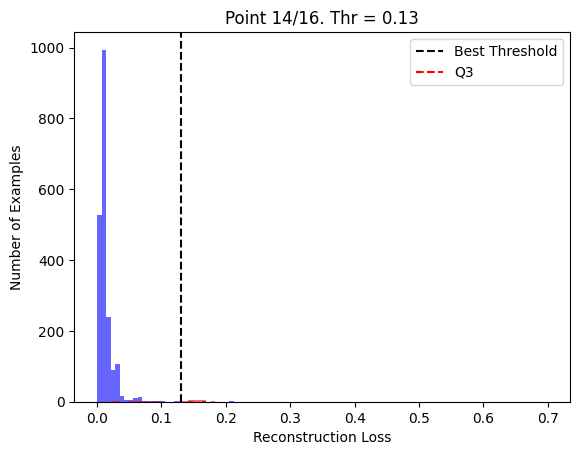

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([ True]), array([368]))
Threshold:  0.12980267
len(test_loss) = len(test_data)?: (368, 368)
Cycle: 14/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
Point 15/16. k = 18.31110191345215


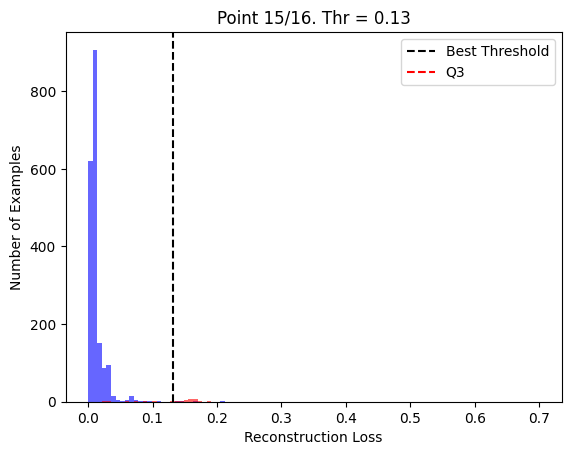

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([ True]), array([489]))
Threshold:  0.1310596
len(test_loss) = len(test_data)?: (489, 489)
Cycle: 15/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Point 16/16. k = 23.14303970336914


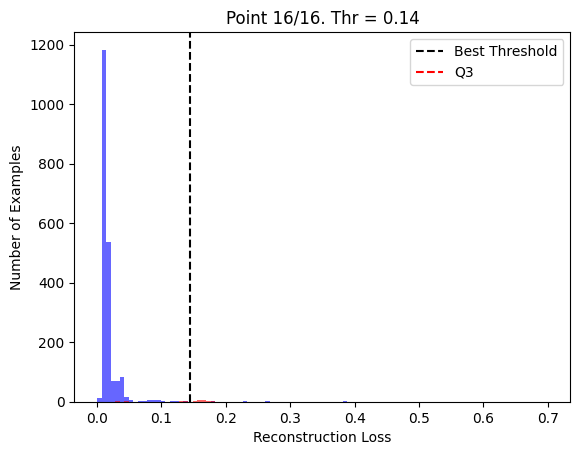

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
pred_aux: (array([False,  True]), array([  1, 442]))
Threshold:  0.1440318
len(test_loss) = len(test_data)?: (443, 443)
Cycle: 16/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([ True]), array([449]))
Threshold:  0.13278429
len(test_loss) = len(test_data)?: (449, 449)
Cycle: 17/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
pred_aux: (array([ True]), array([217]))
Threshold:  0.14060156


In [15]:
n = 1
break_flag = False

#Computing number of cycles
for j in range(100):
    try:
        next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_jul]+pd.Timedelta(days=j*time_delta))
        num_cycles = j+1
    except:
        break


while True:
    try:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=(n+1)*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:last_test_index_2]
        test_labels = labels[last_test_index:last_test_index_2]
        
        batch_limits.append([last_test_index, last_test_index_2])


    except:
        first_val_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=n*time_delta))
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=n*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        test_data = data[last_test_index:]
        test_labels = labels[last_test_index:]
        batch_limits.append([last_test_index, X_input.shape[0]])

        break_flag = True


    val_data = data[first_val_index:last_test_index]
    val_labels = labels[first_val_index:last_test_index]

    if 1 in val_labels: #Update training set
        aux_train_indices = [i for i in range(first_val_index) if labels[i] == 0][-train_len:]  # Get the last train_len normal indices
        normal_train_data = data[aux_train_indices]

    normal_train_data_normalized = np.zeros_like(normal_train_data)
    test_data_normalized = np.zeros_like(test_data)
    val_data_normalized = np.zeros_like(val_data)
    normal_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)
    anomalous_val_data_normalized = np.empty((0, input_dim), dtype=np.float32)


    scaler = MinMaxScaler()
    normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 2 (columns 7-13)
    normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 3 (columns 14-20)
    normal_train_data_normalized[:, 14:21] = scaler.fit_transform(normal_train_data[:, 14:21].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,14:21] = scaler.transform(test_data[:, 14:21].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,14:21] = scaler.transform(val_data[:, 14:21].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 4 (columns 21-27)
    normal_train_data_normalized[:, 21:28] = scaler.fit_transform(normal_train_data[:, 21:28].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,21:28] = scaler.transform(test_data[:, 21:28].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,21:28] = scaler.transform(val_data[:, 21:28].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 5 (columns 28-34)
    normal_train_data_normalized[:, 28:35] = scaler.fit_transform(normal_train_data[:, 28:35].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,28:35] = scaler.transform(test_data[:, 28:35].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,28:35] = scaler.transform(val_data[:, 28:35].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 6 (columns 35-41)
    normal_train_data_normalized[:, 35:42] = scaler.fit_transform(normal_train_data[:, 35:42].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,35:42] = scaler.transform(test_data[:, 35:42].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,35:42] = scaler.transform(val_data[:, 35:42].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 6 (columns 42-48)
    normal_train_data_normalized[:, 42:49] = scaler.fit_transform(normal_train_data[:, 42:49].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,42:49] = scaler.transform(test_data[:, 42:49].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,42:49] = scaler.transform(val_data[:, 42:49].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 7 (columns 49-55)
    normal_train_data_normalized[:, 49:56] = scaler.fit_transform(normal_train_data[:, 49:56].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,49:56] = scaler.transform(test_data[:, 49:56].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,49:56] = scaler.transform(val_data[:, 49:56].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 8 (columns 56-62)
    normal_train_data_normalized[:, 56:63] = scaler.fit_transform(normal_train_data[:, 56:63].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,56:63] = scaler.transform(test_data[:, 56:63].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,56:63] = scaler.transform(val_data[:, 56:63].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 9
    normal_train_data_normalized[:, 63:70] = scaler.fit_transform(normal_train_data[:, 63:70].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,63:70] = scaler.transform(test_data[:, 63:70].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,63:70] = scaler.transform(val_data[:, 63:70].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 10
    normal_train_data_normalized[:, 70:77] = scaler.fit_transform(normal_train_data[:, 70:77].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,70:77] = scaler.transform(test_data[:, 70:77].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,70:77] = scaler.transform(val_data[:, 70:77].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 11
    normal_train_data_normalized[:, 77:84] = scaler.fit_transform(normal_train_data[:, 77:84].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,77:84] = scaler.transform(test_data[:, 77:84].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,77:84] = scaler.transform(val_data[:, 77:84].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 12
    normal_train_data_normalized[:, 84:91] = scaler.fit_transform(normal_train_data[:, 84:91].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,84:91] = scaler.transform(test_data[:, 84:91].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,84:91] = scaler.transform(val_data[:, 84:91].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 13
    normal_train_data_normalized[:, 91:98] = scaler.fit_transform(normal_train_data[:, 91:98].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,91:98] = scaler.transform(test_data[:, 91:98].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,91:98] = scaler.transform(val_data[:, 91:98].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    '''    # Fit and transform sensor 14
    normal_train_data_normalized[:, 98:105] = scaler.fit_transform(normal_train_data[:, 98:105].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,98:105] = scaler.transform(test_data[:, 98:105].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,98:105] = scaler.transform(val_data[:, 98:105].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)'''

    # Fit and transform Trun (column 14)
    normal_train_data_normalized[:, 98] = scaler.fit_transform(normal_train_data[:, 98].reshape(-1, 1)).flatten()
    test_data_normalized[:, 98] = scaler.transform(test_data[:, 98].reshape(-1, 1)).flatten()
    val_data_normalized[:, 98] = scaler.transform(val_data[:, 98].reshape(-1, 1)).flatten()

    # Fit and transform Tidle (column 15)
    normal_train_data_normalized[:, 99] = scaler.fit_transform(normal_train_data[:, 99].reshape(-1, 1)).flatten()
    test_data_normalized[:, 99] = scaler.transform(test_data[:, 99].reshape(-1, 1)).flatten()
    val_data_normalized[:, 99] = scaler.transform(val_data[:, 99].reshape(-1, 1)).flatten()

    if n == 2:
        shap_test_data = test_data_normalized
        shap_test_labels = test_labels 

    #Separate into normal and anomalous data
    for i in range(len(val_labels)):
        if val_labels[i] == False:
            normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
        else:
            anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)

    if 1 in val_labels:
        reconstructions_val_anomalous = autoencoder.predict(anomalous_val_data_normalized)
        val_loss_anomalous = tf.keras.losses.mae(reconstructions_val_anomalous, anomalous_val_data_normalized)
        # Compile the model with the custom loss
        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
        )

        # Train the model
        history = autoencoder.fit(
            x=normal_train_data_normalized,  # Input and target are the same for autoencoders
            y=normal_train_data_normalized,  # Input and target are the same for autoencoders
            epochs=100,
            batch_size=30,
            validation_data=(normal_val_data_normalized, normal_val_data_normalized),
            verbose=0
        )

    ## Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
    reconstructions_val = autoencoder.predict(val_data_normalized)
    val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

    reconstructions_val_normal = autoencoder.predict(normal_val_data_normalized)
    val_loss_normal = tf.keras.losses.mae(reconstructions_val_normal, normal_val_data_normalized)



    if 1 in val_labels:
        y_true = (np.array(val_labels) != 0).astype(int)
        scores = np.array(val_loss)

        # 1. Calculate precision, recall, and thresholds.
        precision, recall, thresholds = precision_recall_curve(y_true, scores)

        # Note: precision and recall arrays have one extra element compared to thresholds.
        # We'll compute F1 scores for the thresholds only.
        # F1 = 2 * (precision * recall) / (precision + recall)
        f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
        # 2. Identify the best threshold (maximizing F1 score)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]

        # Compute quartiles and IQR
        Q1 = np.percentile(val_loss_normal, 25)
        Q3 = np.percentile(val_loss_normal, 75)
        IQR = Q3 - Q1
        # Compute k
        k = (best_threshold - Q3) / IQR
        print(f"Point {n+1}/16. k = {k}")

        plt.hist(val_loss_normal, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
        plt.hist(val_loss_anomalous, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Normal')

        plt.xlabel("Reconstruction Loss")
        plt.ylabel("Number of Examples")
        plt.legend(loc='upper right', handles=[
            plt.Line2D([0], [0], color='black', linestyle='--', label='Best Threshold'),
            plt.Line2D([0], [0], color='red', linestyle='--', label='Q3')
        ])
        plt.title(f"Point {n+1}/16. Thr = {best_threshold:.2f}")
        plt.axvline(x=best_threshold, color='black', linestyle='--')
        #plt.axvline(x=Q3, color='red', linestyle='--')
        #plt.ylim((0, 40))
        plt.show()
        #beta = best_threshold/np.percentile(val_loss, 99)
        


        '''######################################
        plt.figure(figsize=(7, 3))

        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve for Cycle {n+1}/{num_cycles}")
        plt.legend()

        # Plot F1 Score vs. Threshold
        plt.subplot(1, 2, 2)
        plt.plot(thresholds, f1_scores, marker='.', label="F1 Score")
        plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold: {best_threshold:.4f}")
        plt.xlabel("Threshold")
        plt.ylabel("F1 Score")
        plt.title(f"F1 Score vs. Threshold for Cycle {n+1}/{num_cycles}")
        plt.legend()

        plt.tight_layout()
        plt.show()
        ######################################'''
    #Comment out the 'else' if what you want to keep constant is the THRESHOLD and NOT the value of k
    else:
        # Compute quartiles and IQR
        Q1 = np.percentile(val_loss_normal, 25)
        Q3 = np.percentile(val_loss_normal, 75)
        IQR = Q3 - Q1
        best_threshold = Q3 + k * IQR
        #best_threshold = beta*np.percentile(val_loss, 99)
    
    k_list.append(k)
    #beta_list.append(beta)
    threshold_list.append(best_threshold)
    
    
    # Calculate the reconstruction loss for the anomalous test data
    pred_val_aux = pred_aux #former test set is now validation set. Use former cycle's test labels as validation labels in this cycle
    reconstructions_test = autoencoder.predict(test_data_normalized)
    pred_aux = []
    pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy().astype(bool)
    preds_list = np.concatenate((preds_list, pred_aux), axis=0)
    print("pred_aux:", np.unique(pred_aux, return_counts=True))
    print("Threshold: ", best_threshold)

    test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
    if break_flag==True:
        break
    print(f"len(test_loss) = len(test_data)?: {len(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy()), test_data.shape[0]}")
    n += 1

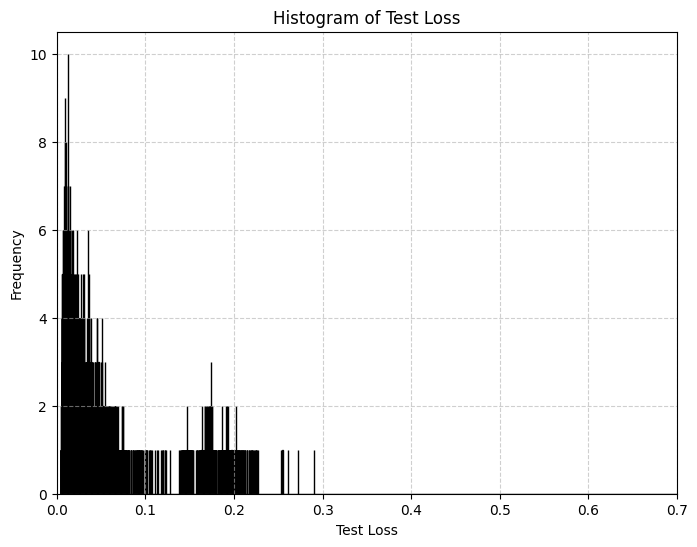

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(test_loss, bins=100000, color='skyblue', edgecolor='black')
plt.title('Histogram of Test Loss')
plt.xlabel('Test Loss')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 0.7)  # Adjust the x-axis limit as needed

# Show the plot
plt.show()

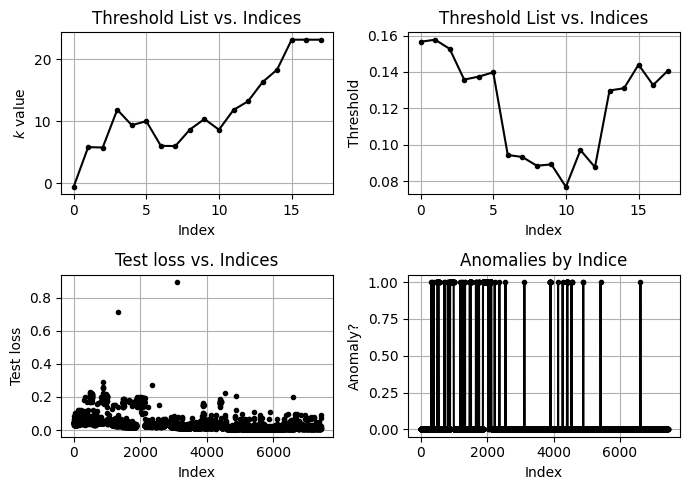

In [17]:
plt.figure(figsize=(7, 5))

# Plot k_list against the respective indices
plt.subplot(2, 2, 1)
plt.plot(k_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('$k$ value')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot threshold_list against the respective indices
plt.subplot(2, 2, 2)
plt.plot(threshold_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)

# Plot test_loss against the respective indices
plt.subplot(2, 2, 3)
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)

# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.subplot(2, 2, 4)
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)

plt.tight_layout()
plt.show()

## Metrics and Confusion Matrix

In [18]:
len(data[next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)):])


7095

In [19]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
conf_matrix_list = []

# Reshape test_loss to a 2D array and fit and transform it
test_loss_normalized = scaler.fit_transform(np.array(test_loss).reshape(-1, 1)).flatten()
aux_index = index_mai
anomaly_list_binary = np.array(anomaly_list[aux_index:], dtype=int)

def compute_f1_for_threshold(anomaly_list_binary, test_loss_normalized, threshold):
    predicted_anomalies = (tf.convert_to_tensor(test_loss_normalized) >= threshold).numpy().astype(int)
    return f1_score(anomaly_list_binary, predicted_anomalies), predicted_anomalies

for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index
    # Function to compute F1-score for a given threshold
    # Search for the best threshold
    thresholds = np.linspace(0, 1, 10000)
    best_threshold = threshold_list[i]
    best_f1, best_predictions = compute_f1_for_threshold(anomaly_list_binary[start_idx:end_idx], test_loss[start_idx:end_idx], best_threshold)
    # Compute confusion matrix
    conf_matrix_list.append(confusion_matrix(anomaly_list_binary[start_idx:end_idx], best_predictions, labels=[0, 1]))

c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavi

Segment 0: start=0, end=338, threshold=0.15662485361099243
Segment 1: start=338, end=622, threshold=0.15776610374450684
Segment 2: start=622, end=1157, threshold=0.15273435413837433
Segment 3: start=1157, end=1468, threshold=0.13581623136997223
Segment 4: start=1468, end=1937, threshold=0.13744665682315826
Segment 5: start=1937, end=2386, threshold=0.1398090422153473
Segment 6: start=2386, end=2925, threshold=0.09433256834745407
Segment 7: start=2925, end=3241, threshold=0.0932377278804779
Segment 8: start=3241, end=3631, threshold=0.08841846138238907
Segment 9: start=3631, end=4081, threshold=0.08915878087282181
Segment 10: start=4081, end=4601, threshold=0.07679421454668045
Segment 11: start=4601, end=5051, threshold=0.09702811390161514
Segment 12: start=5051, end=5467, threshold=0.08762349933385849
Segment 13: start=5467, end=5835, threshold=0.1298026740550995
Segment 14: start=5835, end=6324, threshold=0.13105960190296173
Segment 15: start=6324, end=6767, threshold=0.14403179287910

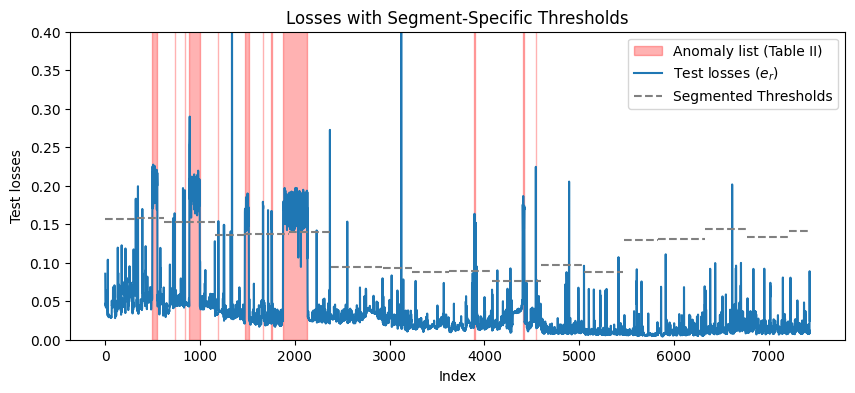

In [20]:
# Plot test losses
aux_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai])
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, 
                 color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.plot(test_loss, label="Test losses ($e_r$)", linestyle='-')

# Plot segmented threshold lines
for i in range(len(threshold_list)):
    start_idx = batch_limits[i][0] - batch_limits[0][0]  # Start index of the segment
    end_idx = batch_limits[i][1] - batch_limits[0][0]  # End index

    print(f"Segment {i}: start={start_idx}, end={end_idx}, threshold={threshold_list[i]}")
    
    # Ensure non-overlapping segments
    if start_idx < end_idx:
        plt.plot(range(start_idx, end_idx), 
                 threshold_list[i]*np.ones(end_idx - start_idx), 
                 linestyle='--', color='gray')

# Add legend for threshold
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label="Segmented Thresholds")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')

# Formatting
plt.title('Losses with Segment-Specific Thresholds')
plt.xlabel('Index')
plt.ylabel('Test losses')
plt.ylim((0, 0.4))
plt.show()

Confusion Matrix = 
| True Negatives |     False Positives |
| -------------  |  --------------- |
| **False Negatives**   |  **True Positives** |

In [21]:
cm = np.sum(conf_matrix_list, axis=0)
TN, FP, FN, TP = cm.ravel()

# Computing metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = (TP / (TP + FP)) if (TP + FP) > 0 else 0
recall = (TP / (TP + FN)) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

# Display results
print("Confusion Matrix with custom thresholds:")
print(f"{cm}\n")

print(f"Accuracy = {100*accuracy:.2f}%")
print(f"Precision = {100*precision:.2f}%")
print(f"Recall = {100*recall:.2f}%")
print(f"F1 Score = {100*f1_score:.2f}%")

Confusion Matrix with custom thresholds:
[[6888   40]
 [  17  488]]

Accuracy = 99.23%
Precision = 92.42%
Recall = 96.63%
F1 Score = 94.48%


Confusion Matrix with custom thresholds:\
[[6888   40]\
 [  16  489]]

Accuracy = 99.25%\
Precision = 92.44%\
Recall = 96.83%\
F1 Score = 94.58%

## Root cause analysis - SHAP values

In [22]:
testdf[11878:].shape[0]

0

In [23]:
index_mai

4193

In [24]:
len(test_loss)

7433

In [25]:
import shap

# Wrapper: SHAP expects NumPy, so we convert inputs
def reconstruction_mse(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    recon = autoencoder(x_tensor)
    loss = tf.reduce_mean(tf.math.squared_difference(x_tensor, recon), axis=1)  # shape: (n_samples,)
    return loss.numpy()

def aggregate_sensor_shap(shap_vals):
    shap_sensor = np.zeros((shap_vals.shape[0], 14))
    for i in range(14):
        start = i * 7
        end = start + 7
        shap_sensor[:, i] = np.sum(np.abs(shap_vals[:, start:end]), axis=1)  # abs to get magnitude
    return shap_sensor

In [26]:
test_data_normalized.shape

(217, 100)

In [27]:
len(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())

217

In [28]:
X_train_sample = normal_train_data_normalized[-100:]

# Compute reconstruction losses for the test set
reconstructions_shap_test = autoencoder.predict(shap_test_data)
reconstruction_losses = tf.keras.losses.mae(reconstructions_shap_test, shap_test_data).numpy()

# Get indices sorted by loss (descending order)
sorted_indices = np.argsort(reconstruction_losses)[::-1]

# Reorder test_data_normalized and test_labels by sorted_indices
sorted_test_data = shap_test_data[sorted_indices]
sorted_test_labels = shap_test_labels[sorted_indices]

# Select top 10 samples where test_label == 1 (anomaly)
top_anomalous_samples = []
count = 0
for i in range(len(sorted_test_labels)):
    if sorted_test_labels[i] == 1:
        top_anomalous_samples.append(sorted_test_data[i])
        count += 1
        if count == 10:
            break

X_test = np.array(top_anomalous_samples)
X_test.shape  # (10, input_dim)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(10, 100)

In [29]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

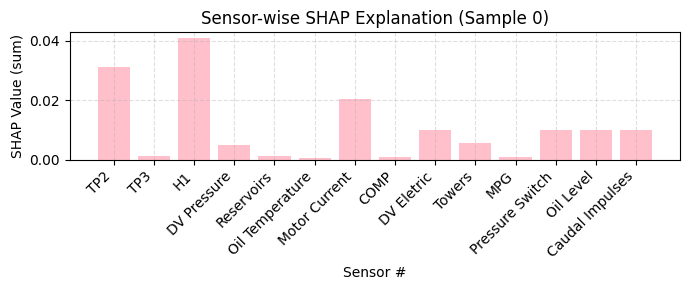

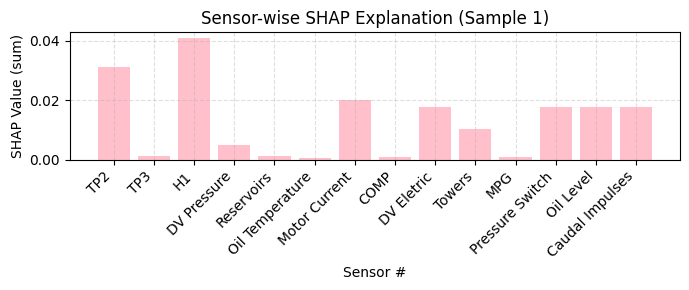

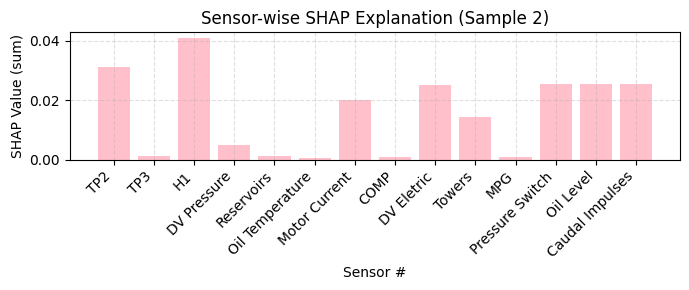

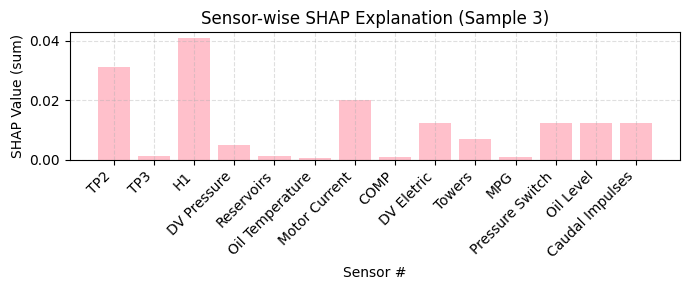

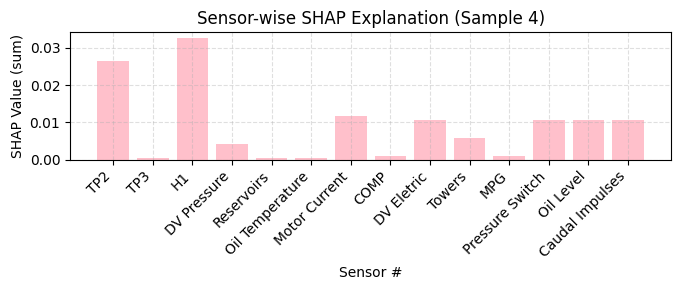

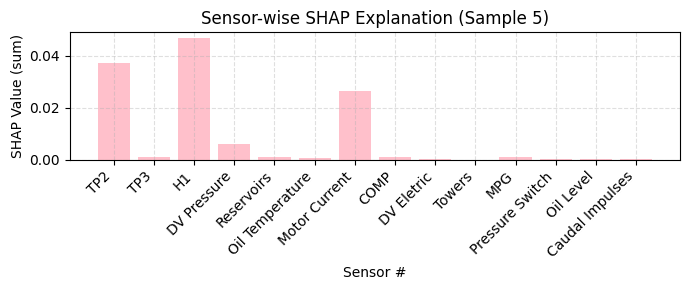

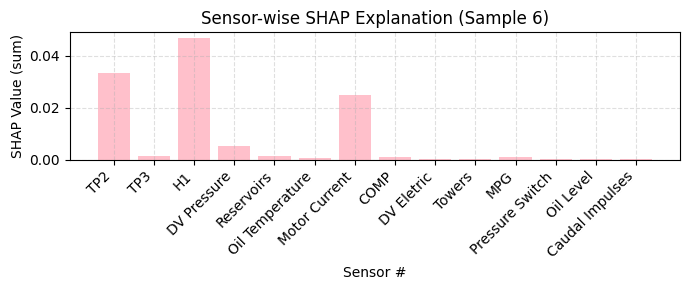

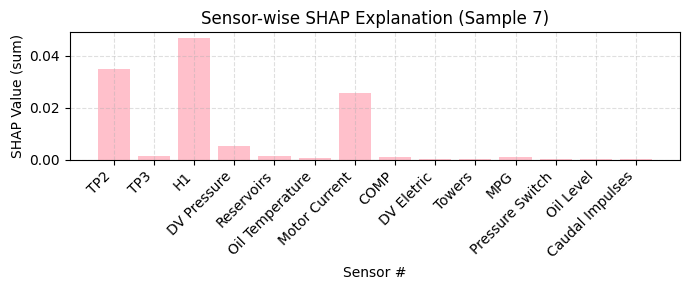

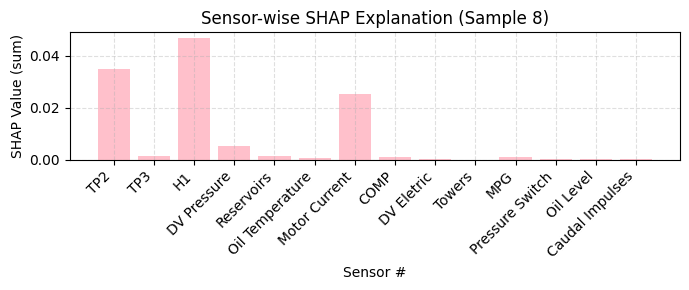

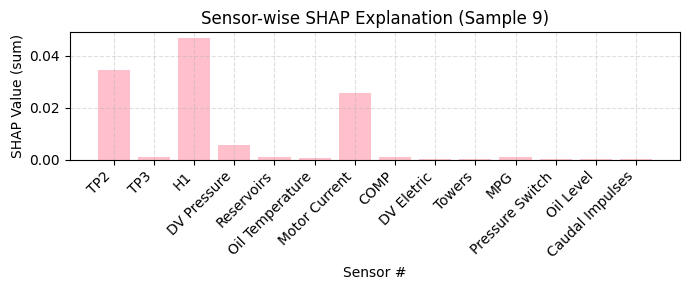

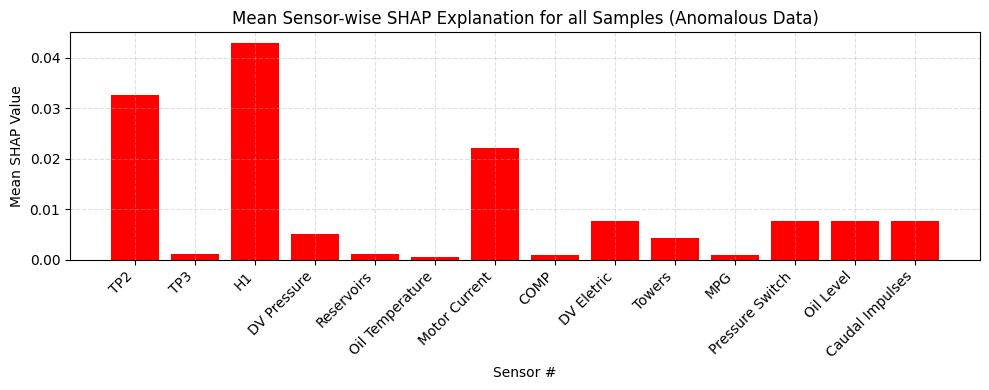

In [30]:
def plot_sensor_shap_values(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

    sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                     'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                     'Oil Level','Caudal Impulses']

    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 15), sensor_shap_vals, color='pink')
    plt.xlabel('Sensor #')
    plt.ylabel(f'SHAP Value ({agg_fn})')
    plt.title(f'Sensor-wise SHAP Explanation (Sample {sample_idx})')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals, color='red')
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation for all Samples (Anomalous Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### SHAP for good data

In [31]:
X_train_sample = normal_train_data_normalized[-100:]

X_test = X_train_sample[np.random.choice(len(X_train_sample), size=10, replace=False)]

X_test = np.array(X_test)
X_test.shape  # (10, input_dim)

(10, 100)

In [32]:
explainer = shap.Explainer(reconstruction_mse, X_train_sample)  # Use a subset of normal data as the background
shap_values = explainer(X_test)  # X_test shape: (n_samples, 100)
shap_values.values.shape  # -> (n_samples, 100)
sensor_shap_values = aggregate_sensor_shap(shap_values.values)

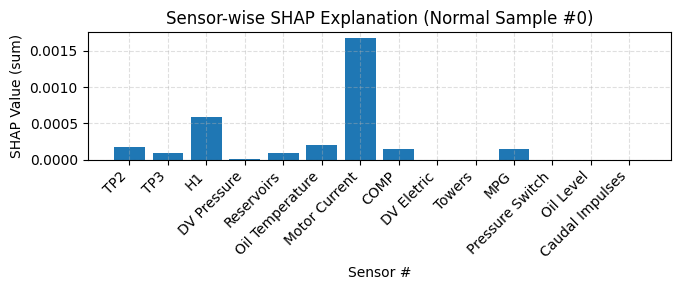

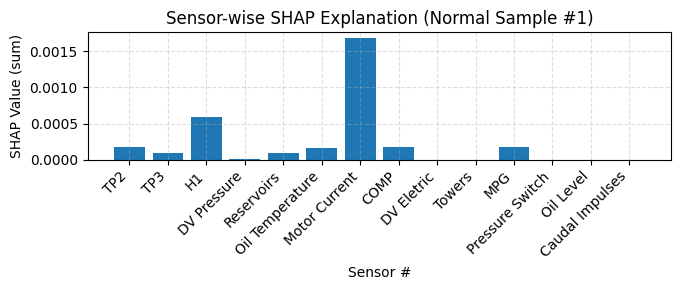

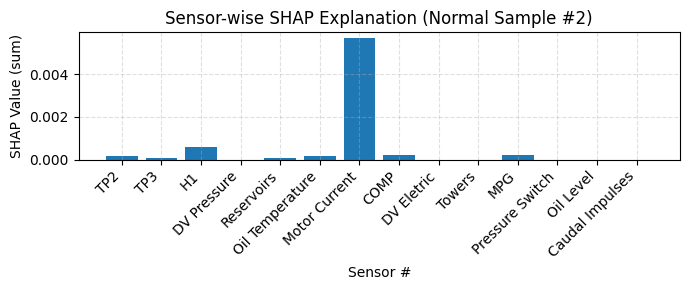

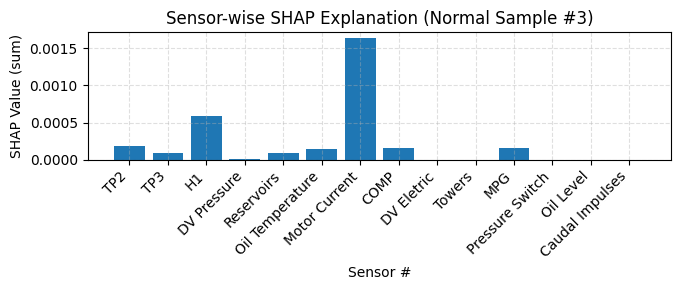

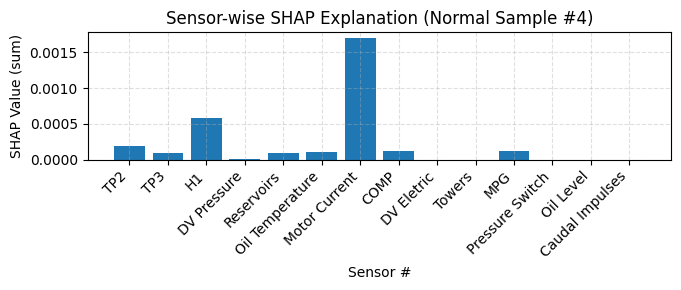

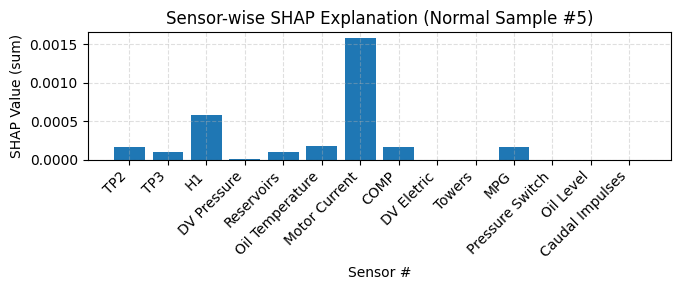

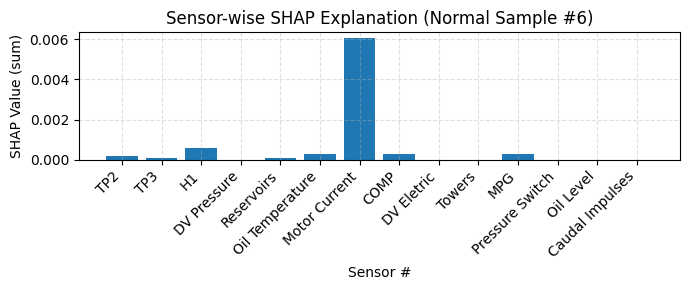

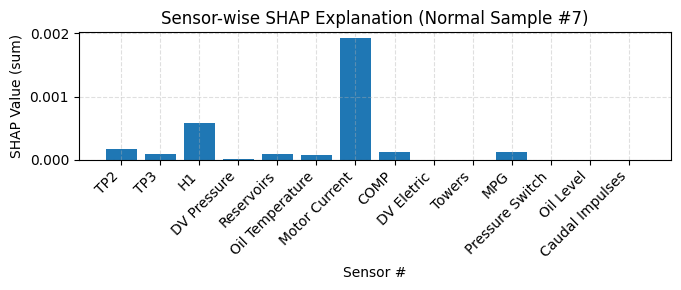

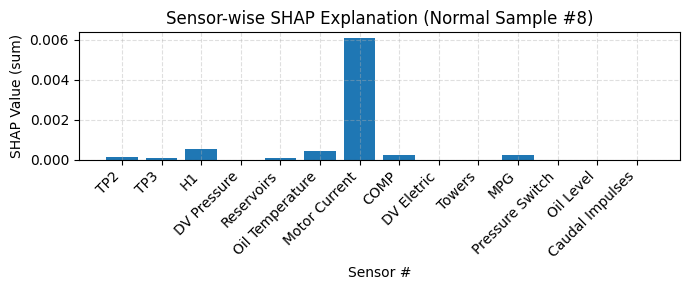

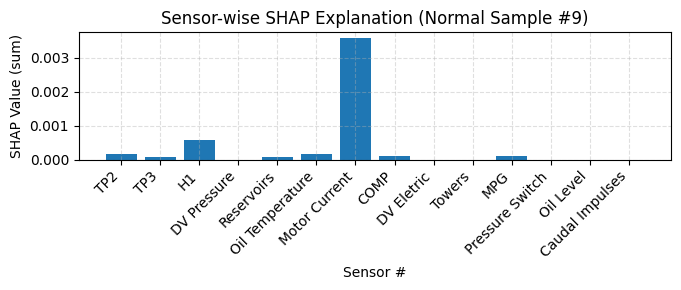

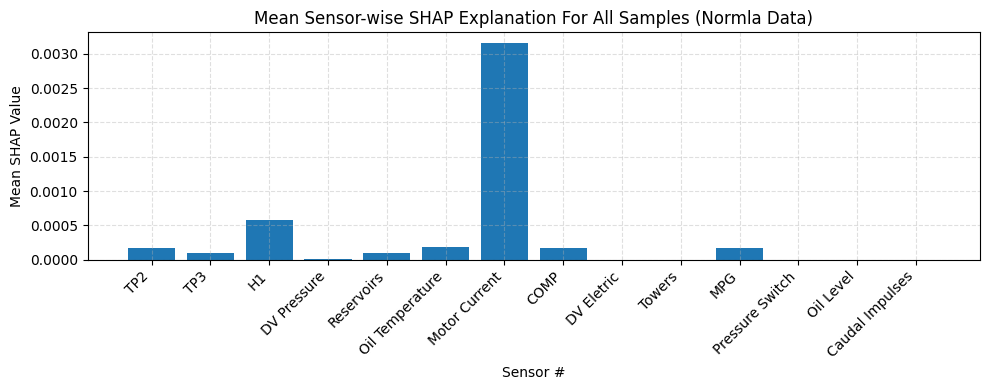

In [33]:
def plot_sensor_shap_values(shap_values, sample_idx=0, agg_fn='sum', return_vals=False):
    """
    Plots SHAP values aggregated by sensor for a single sample.
    
    If return_vals=True, returns the aggregated SHAP values instead of plotting.
    """
    shap_vals = shap_values.values[sample_idx]  # shape: (100,)
    sensor_shap_vals = []

    for i in range(14):
        start = i * 7
        end = start + 7
        sensor_points = shap_vals[start:end]
        if agg_fn == 'sum':
            aggregated = np.sum(np.abs(sensor_points))
        else:
            aggregated = np.mean(np.abs(sensor_points))
        sensor_shap_vals.append(aggregated)

    if return_vals:
        return sensor_shap_vals

    sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                     'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                     'Oil Level','Caudal Impulses']

    plt.figure(figsize=(7, 3))
    plt.bar(range(1, 15), sensor_shap_vals)
    plt.xlabel('Sensor #')
    plt.ylabel(f'SHAP Value ({agg_fn})')
    plt.title(f'Sensor-wise SHAP Explanation (Normal Sample #{sample_idx})')
    plt.xticks(range(1, 15), sensor_labels, rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


# Store all sensor-wise SHAP values
all_sensor_vals = []

i = 0
while True:
    try:
        vals = plot_sensor_shap_values(shap_values, sample_idx=i, return_vals=True)
        all_sensor_vals.append(vals)
        plot_sensor_shap_values(shap_values, sample_idx=i)
        i += 1
    except:
        break

# Compute mean SHAP values across samples
mean_vals = np.mean(all_sensor_vals, axis=0)

# Plot the mean SHAP values
sensor_labels = ['TP2','TP3','H1','DV Pressure','Reservoirs','Oil Temperature',
                 'Motor Current','COMP','DV Eletric','Towers','MPG','Pressure Switch',
                 'Oil Level','Caudal Impulses']

plt.figure(figsize=(10, 4))
plt.bar(range(1, 15), mean_vals)
plt.xlabel('Sensor #')
plt.ylabel('Mean SHAP Value')
plt.title('Mean Sensor-wise SHAP Explanation For All Samples (Normla Data)')
plt.xticks(range(1, 15), sensor_labels,rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Verifying SHAP results

In [58]:
[i for i in range(1,14)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

[[8.7355447e-01 9.7156394e-01 1.1374407e-03 1.3270142e-03 1.5165876e-03
  1.3270142e-03 1.3270142e-03 8.2679093e-01 9.5853770e-01 9.6000969e-01
  9.0186453e-01 8.5402358e-01 8.0569184e-01 7.6373899e-01 9.7943202e-04
  1.3712049e-03 9.6709114e-01 9.2027420e-01 8.8188046e-01 8.4368271e-01
  8.0999023e-01 1.4819205e-03 1.1855364e-03 1.4819205e-03 1.4819205e-03
  1.4819205e-03 1.4819205e-03 1.1855364e-03 8.2757771e-01 9.5860875e-01
  9.6032321e-01 9.0227771e-01 8.5476363e-01 8.0651474e-01 7.6463377e-01
  8.2805037e-01 9.2531466e-01 9.4528866e-01 9.0707755e-01 8.5844541e-01
  8.4324789e-01 8.0199730e-01 9.2911190e-01 9.7809631e-01 6.3042611e-01
  6.1847866e-01 6.1011547e-01 3.5842294e-03 3.1859814e-03 0.0000000e+00
  8.8495575e-03 1.0619469e-01 1.0619469e-01 1.0619469e-01 1.0619469e-01
  9.7345129e-02 9.4492437e-04 9.4492437e-04 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.6997839e-04 2.7005130e-04 6.7512825e-04
  1.6203078e-03 1.6203078e-03 1.6203078e-03 1.6203078e-03 1.4852

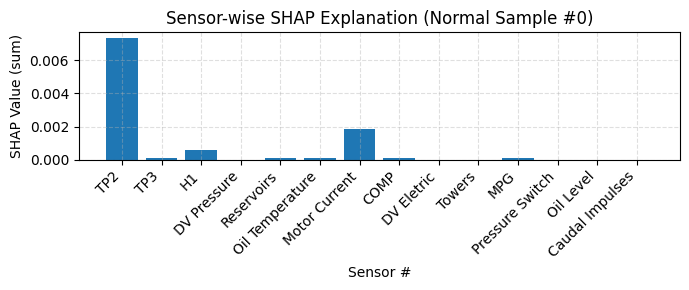

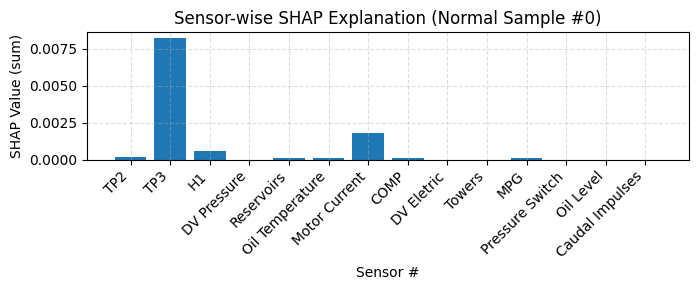

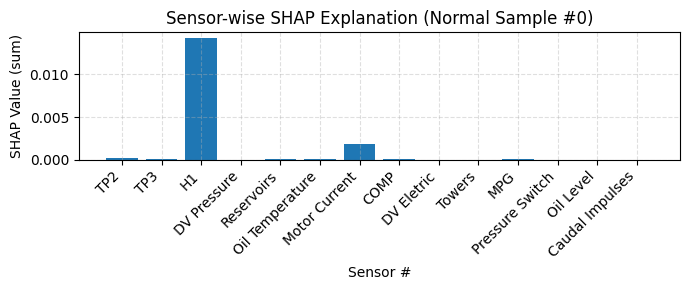

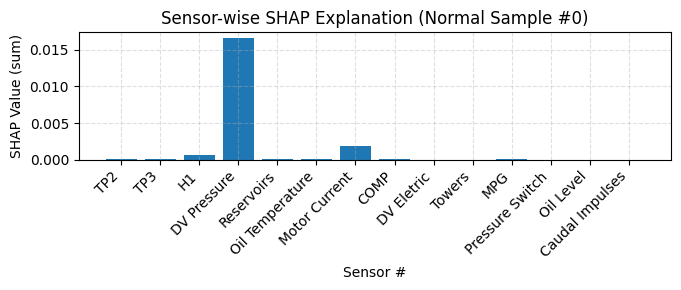

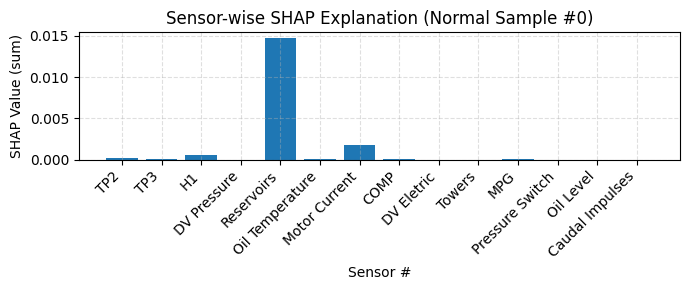

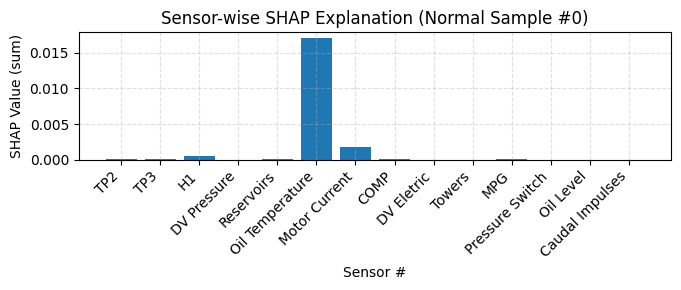

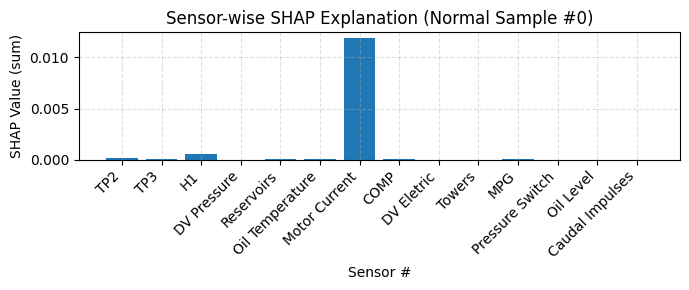

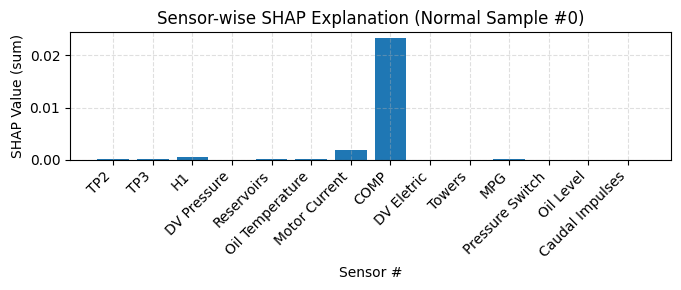

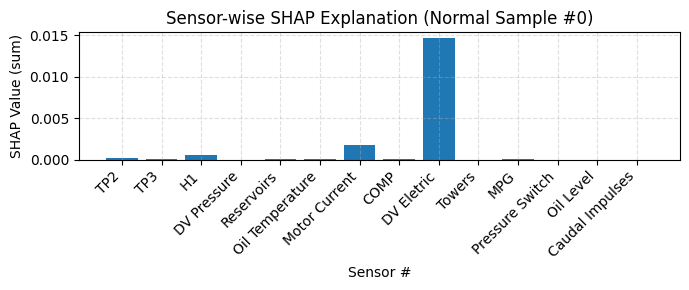

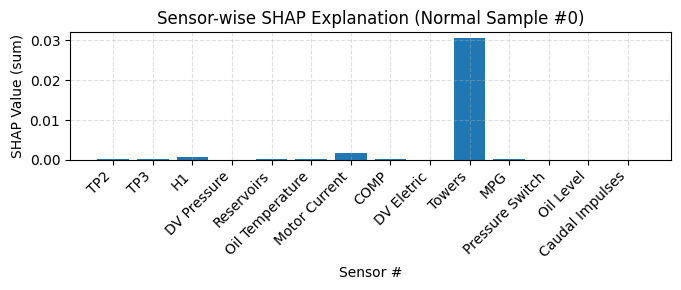

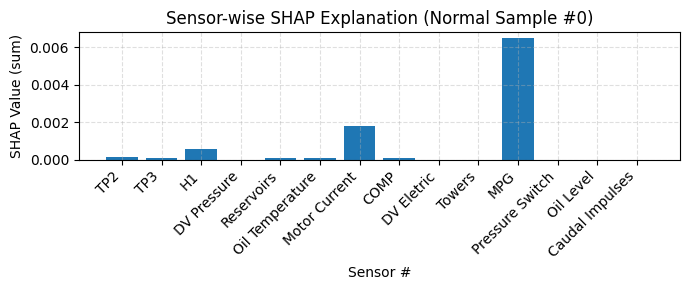

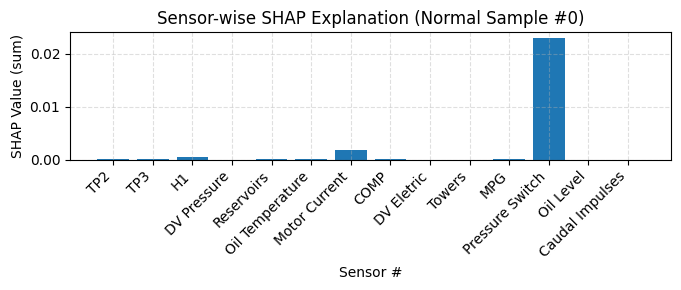

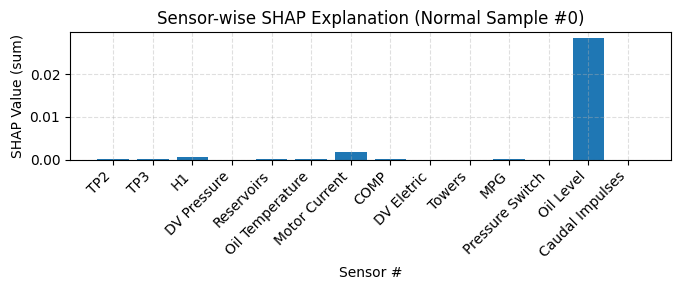

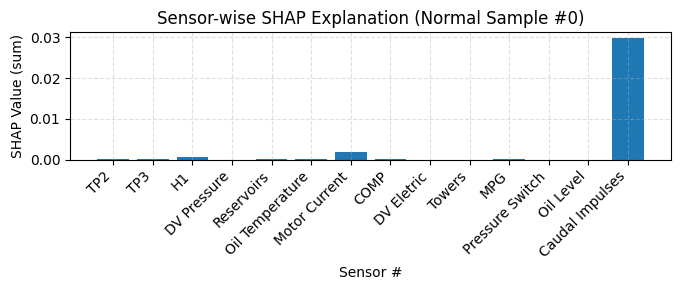

In [61]:
# Create synthetic anomaly by corrupting one sensor's data
synthetic_sample = X_train_sample[8:9].copy()
print(synthetic_sample) # Add large offset

for i in range(14):
    synthetic_sample_aux = synthetic_sample.copy()
    synthetic_sample_aux[0][i*7:(i+1)*7] = np.random.rand(7)

    # Compute SHAP for this sample
    synth_shap = explainer(synthetic_sample_aux)
    plot_sensor_shap_values(synth_shap)